# Final Project: Phase 2

---

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import json
import warnings
warnings.filterwarnings('ignore')

## Reimporting

First, let's reimport all of the data we finalized during our EDA session.

In [2]:
df = pd.read_csv("./project_data/USVideos.csv")

with open("./project_data/US_category_id.json") as f:
    categories = json.load(f)

cat_map = {}
for index,cat in enumerate(categories["items"]):
    cat_map[int(cat["id"])]=cat["snippet"]["title"]
    
df["category"] = df["category_id"].map(cat_map)

data = df[["title","channel_title","category","description","tags","views"]]

data["log_views"] = np.log(data["views"]+1)

Let's take stock of what we have:

In [3]:
data.head()

,title,channel_title,category,description,tags,views,log_views
0,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,People & Blogs,SHANTELL'S CHANNEL - https://www.youtube.com/s...,SHANtell martin,748374,13.525659
1,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,Entertainment,"One year after the presidential election, John...","last week tonight trump presidency|""last week ...",2418783,14.698775
2,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,Comedy,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,14.975981
3,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,Entertainment,Today we find out if Link is a Nickelback amat...,"rhett and link|""gmm""|""good mythical morning""|""...",343168,12.745978
4,I Dare You: GOING BALD!?,nigahiga,Entertainment,I know it's been a while since we did this sho...,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,14.555413


## Splitting into Train/Test

First, we split our dataset into features and class variables.

In [4]:
X = data.drop("views",axis=1)
Y = data["log_views"]

(array([  122.,   517.,  1184.,  3361.,  8463., 13728.,  9532.,  3116.,
          821.,   105.]),
 array([ 6.30991828,  7.60218169,  8.8944451 , 10.18670852, 11.47897193,
        12.77123534, 14.06349875, 15.35576216, 16.64802558, 17.94028899,
        19.2325524 ]),
 <a list of 10 Patch objects>)

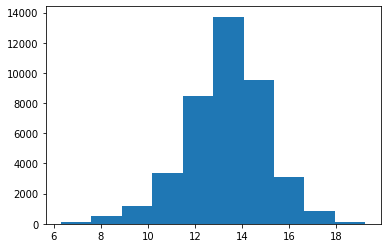

In [5]:
import matplotlib.pyplot as plt
plt.hist(Y)

Now, when we're doing our train test split, we want to make sure we keep videos that come from this same user together. This is to make sure we're not predicting view count based off of how popular an individual channel is.

In [6]:
from sklearn.model_selection import GroupShuffleSplit
# This code makes the splits, but keeps rows wtih the same channel title in the same split
train_inds, test_inds = next(GroupShuffleSplit(random_state=42).split(X, groups=df['channel_title']))
X_train_raw = X.iloc[train_inds]
y_train = Y.iloc[train_inds]

X_test_raw = X.iloc[test_inds]
y_test = Y.iloc[test_inds]

In [7]:
# Checking to see if they're together
X["channel_title"].value_counts().head()

ESPN                                      203
The Tonight Show Starring Jimmy Fallon    197
TheEllenShow                              193
Vox                                       193
Netflix                                   193
Name: channel_title, dtype: int64

In [8]:
X_train_raw["channel_title"].value_counts().head()

TheEllenShow         193
Vox                  193
Jimmy Kimmel Live    186
Screen Junkies       182
NBA                  181
Name: channel_title, dtype: int64

In [9]:
X_test_raw["channel_title"].value_counts().head()

ESPN                                      203
The Tonight Show Starring Jimmy Fallon    197
Netflix                                   193
The Late Show with Stephen Colbert        187
Late Night with Seth Meyers               183
Name: channel_title, dtype: int64

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Feature Transformation

Use your training data to fit any transformers or encoder your need, then apply the fit transformer to your test data. This applies to:
* Normalizing/standardizing your features
* Using Bag of Words or TF-IDF to encode strings
* PCA or dimensionality reduction

**Rationale**: In practice, we won't be able to see the test data we'll be making predicting for, so we shouldn't use that data as the basis for any transformation or feature extraction.

Here, we **only take the top N** words when doing our count vectors. We do this because to use the full word list would be infeasable since there are so many. Also, due to the nature of language, there are probably only a few words that are used frequently - but many words used only once.

In [11]:
# This function applies our feature transformation to our training and test data
# top_n

def apply_feature_transformation(X_train, X_test,top_n=100):
    # First, create and fit our vectorizers on the training data
    # We only take the top_n words into consideration, and simply ignore anything outside of that
    tag_vectorizer = CountVectorizer(token_pattern=r"([^|]+)", max_features=top_n)
    tag_vectors = tag_vectorizer.fit_transform(X_train["tags"].str.replace("\"","")).toarray()
    # print(f'Tag features: {tag_vectorizer.vocabulary_.keys()}')

    description_vectorizer = CountVectorizer(max_features=top_n)
    description_vectors = description_vectorizer.fit_transform(X_train["description"].values.astype('U')).toarray()
    # print(f'Description features: {description_vectorizer.vocabulary_.keys()}')

    title_vectorizer = CountVectorizer(max_features=top_n)
    title_vectors = title_vectorizer.fit_transform(X_train["title"]).toarray()
    # print(f'Title features: {title_vectorizer.vocabulary_.keys()}')

    # Next, we concatinate the tag, description, and title vectors into one vector
    # This is so we can have one "object" that we can fit into our models
    # Therefore, this will create a matrix of size [num_train_instances * (3 * top_n)]
    X_train_transfomed = np.concatenate((tag_vectors, description_vectors, title_vectors), axis=1)
    
    # Now we fit our test data
    # This will create a matrix of size [num_test_instances * (3 * top_n)]
    X_test_transformed = np.concatenate(
        (
            tag_vectorizer.transform(X_test["tags"].str.replace("\"","")).toarray(),
            description_vectorizer.transform(X_test["description"].values.astype('U')).toarray(),
            title_vectorizer.transform(X_test["title"]).toarray()
        ),
        axis=1
    )
    
    return X_train_transfomed, X_test_transformed

Note that we could also treat the "top_n" features as a hyperparameter and tune it just like the others, but for now we'll stick with 1000.

In [12]:
X_train_all, X_test_all = apply_feature_transformation(X_train_raw,X_test_raw, 1000)

In [13]:
# Checking to make sure we shaped our features right
# There should be 3*top_n features
X_train_all.shape

(32450, 3000)

In [14]:
X_test_all.shape

(8499, 3000)

Let's see if these features are any good by plotting a histogram of their respective correlations with the Y variable:

(array([6.000e+00, 4.500e+01, 5.550e+02, 1.352e+03, 8.030e+02, 1.730e+02,
        5.400e+01, 7.000e+00, 4.000e+00, 1.000e+00]),
 array([-0.11728356, -0.0836255 , -0.04996744, -0.01630939,  0.01734867,
         0.05100673,  0.08466478,  0.11832284,  0.1519809 ,  0.18563895,
         0.21929701]),
 <a list of 10 Patch objects>)

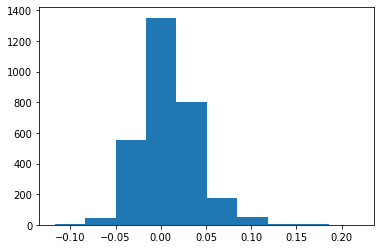

In [15]:
plt.hist([np.corrcoef(X_train_all[:,i], y_train)[0,1] for i in range(X_train_all.shape[1])])

Seems like most of them are rather unhelpful. We can filter them, but remember we can only use y_train to do so...

We can use [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) from sklearn to select the K best features, and use the [f_regression](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression) test to measure the goodness of each feature (essentially, how well it performs in a single-variable regression).

In [16]:
from sklearn.feature_selection import SelectKBest, f_regression

feature_selector = SelectKBest(f_regression, k=100).fit(X_train_all, y_train)
X_train = feature_selector.transform(X_train_all)
X_test = feature_selector.transform(X_test_all)

Now we only have non-0 correlated features.

(array([ 6.,  2.,  0.,  0.,  0., 26., 54.,  7.,  4.,  1.]),
 array([-0.11728356, -0.0836255 , -0.04996744, -0.01630939,  0.01734867,
         0.05100673,  0.08466478,  0.11832284,  0.1519809 ,  0.18563895,
         0.21929701]),
 <a list of 10 Patch objects>)

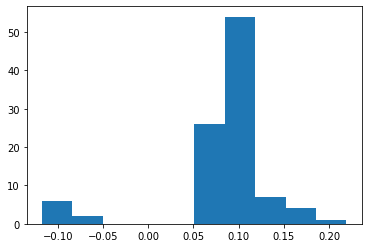

In [17]:
plt.hist([np.corrcoef(X_train[:,i], y_train)[0,1] for i in range(X_train.shape[1])])

# Trying Different Models

Now that we have our data fully preprocessed, let's try it with some different models to see what we can get.

### Linear Regression

It's always good to work your way up from the simplest models you know before trying the more complicated ones. So let's see if a simple linear regression will solve our problem.

In [18]:
from sklearn.linear_model import LinearRegression

In [19]:
reg = LinearRegression().fit(X_train, y_train)

In this case we get the model's score. By default that's $R^2$ (not RMSE). Remember this can be interpreted as the proportion of the data's variance explained by the model.

In [20]:
print("Training score", reg.score(X_train,y_train))
print("Testing score:", reg.score(X_test,y_test))

Training score 0.23023058062865775
Testing score: 0.09132333225476563


Eugh. Looks like linear regression isn't powerful enough for this problem. There's no use trying to tune this model if even the base accuracy doesn't look promising.

**Note**: A negative $R^2$ is possible, despite the "squared" in the name. That means the model is fitting very poorly - worse than a model that just predicted the average views for every video. So at least we're doing better than that!

### Lasso Regression

Maybe our model is overfitting. Could Lasso fix that?

In [21]:
from sklearn.linear_model import LassoCV

In [22]:
# Warning: Since this model has built-in CV hyperparameter tuning, it's going to take a while to run!
lasso = LassoCV(n_alphas=10).fit(X_train, y_train)

We get score ($R^2$) again. Compare to the linear regression above.

In [23]:
print("Training score", lasso.score(X_train,y_train))
print("Testing score:", lasso.score(X_test,y_test))

Training score 0.2279542041870302
Testing score: 0.09446190906546902


The model is still fitting quite poorly - perhaps we need *more* complexity. Let's try an ANN.

### Multi Layer Perceptron Regression

Let's see if we can squeeze anything out of a neural network.

In [24]:
from sklearn.neural_network import MLPRegressor

In [25]:
nn = MLPRegressor(max_iter=45, hidden_layer_sizes = (300,100,50))
nn.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(300, 100, 50), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=45, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [26]:
nn.score(X_train,y_train)

0.7329176791516323

In [27]:
nn.score(X_test,y_test)

-0.5947372173388692

Our model has much better training score! But also no better testing. Sounds like it's too complex. Let's try fewer hidden laers/nodes.

In [50]:
nn2 = MLPRegressor(max_iter=45, random_state=42, hidden_layer_sizes = (3))
nn2.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=3, learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=45, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=42, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [51]:
nn2.score(X_train,y_train)

0.2276667278686788

In [52]:
nn2.score(X_test,y_test)

0.08545794325932077

### Hyperparameter Tuning

Sounds like a single layer works about as well as regression. Now lets use hyperparameter tuning to tune it fairly (rather than peaking at our test set).

In [53]:
from sklearn.model_selection import GridSearchCV

def find_best_hyperparameters_m1(X_train, Y_train):
    """
    Input: The training X features and Y labels/values
    Output: The classifier with the best hyperparams and the predictions
    """
    clf = MLPRegressor(max_iter=45)
    param_grid = {  'hidden_layer_sizes': [(3), (7), (11)],
                    'activation': ['tanh', 'relu'],
                    'alpha': [0.0001, 0.05],}
    
    search = GridSearchCV(clf, param_grid, cv=2)
    search.fit(X_train,y_train)
    return search, search.predict(X_test)

In [ ]:
search = find_best_hyperparameters_m1(X_train, y_train)

Our best estimator seems to use a relu activation with 7 hidden layers.

In [60]:
search[0].best_estimator_

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=7, learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=45, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [56]:
model = search[0]
model.score(X_train,y_train)

0.27454625633871776

In [57]:
model.score(X_test,y_test)

0.05601606871451626

Ultimately, that model does worse than the one where we selected the hyperparameters using the test dataset by manually searching, but that makes sense.